## Image augmentation

Here I am using the new Ubuntu-python2 environment.

--------

Image classification needs to learn an invariant representation of the image. 

Size: scale invariance.

Angle: rotation invarinace.

Position: translation invariance. 

=> Expand training set by augmenting the data.

Use `ImageDataGenerator`

Using as reference the `cifar10_augmentation` jupyter notebook from class.

In [1]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


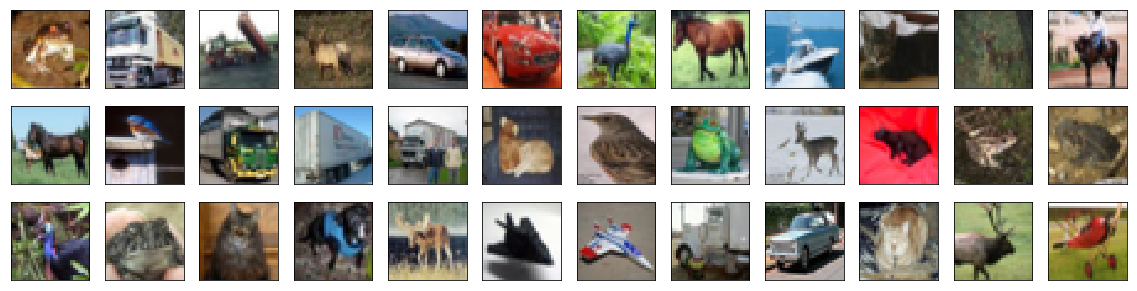

In [2]:
'''
Visualize first 24 training images
'''

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

In [3]:
'''
Rescale and break dataset
'''

# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

('x_train shape:', (45000, 32, 32, 3))
(45000, 'train samples')
(10000, 'test samples')
(5000, 'validation samples')


### Create and configure Augmented Image Generator (* Use modified version instead)

Check [this keras link](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

Also [the Keras Documentation on ImageDataGenerator](https://keras.io/preprocessing/image/)

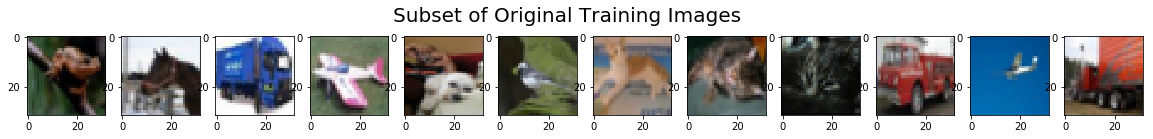

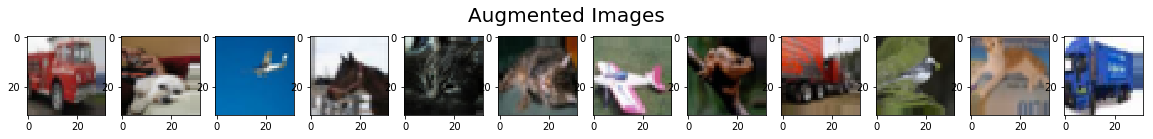

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

'''
Visualize original and augmented images
'''

import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [5]:
'''
Model Architecture
'''

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
__________

In [6]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

'''
Note on `steps_per_epoch`, the second parameter of `fit_generator`:

`x_train.shape[0]` corresponds to the number of unique samples in the training dataset x_train. 
By setting steps_per_epoch to this value, 
we ensure that the model sees x_train.shape[0] augmented images in each epoch.
'''

Epoch 1/100
Epoch 00001: val_loss improved from inf to 1.35775, saving model to aug_model.weights.best.hdf5
 - 28s - loss: 1.6433 - acc: 0.4075 - val_loss: 1.3578 - val_acc: 0.5188
Epoch 2/100
Epoch 00002: val_loss improved from 1.35775 to 1.17967, saving model to aug_model.weights.best.hdf5
 - 28s - loss: 1.3526 - acc: 0.5158 - val_loss: 1.1797 - val_acc: 0.5773
Epoch 3/100
Epoch 00003: val_loss did not improve
 - 27s - loss: 1.2500 - acc: 0.5583 - val_loss: 1.1943 - val_acc: 0.5891
Epoch 4/100
Epoch 00004: val_loss improved from 1.17967 to 1.05642, saving model to aug_model.weights.best.hdf5
 - 27s - loss: 1.1893 - acc: 0.5839 - val_loss: 1.0564 - val_acc: 0.6258
Epoch 5/100
Epoch 00005: val_loss improved from 1.05642 to 1.04748, saving model to aug_model.weights.best.hdf5
 - 27s - loss: 1.1513 - acc: 0.5974 - val_loss: 1.0475 - val_acc: 0.6306
Epoch 6/100
Epoch 00006: val_loss improved from 1.04748 to 1.02087, saving model to aug_model.weights.best.hdf5
 - 29s - loss: 1.1431 - acc: 

Epoch 64/100
Epoch 00064: val_loss did not improve
 - 28s - loss: 1.8283 - acc: 0.3627 - val_loss: 1.8243 - val_acc: 0.3287
Epoch 65/100
Epoch 00065: val_loss did not improve
 - 28s - loss: 1.8279 - acc: 0.3544 - val_loss: 1.6053 - val_acc: 0.4201
Epoch 66/100
Epoch 00066: val_loss did not improve
 - 26s - loss: 1.8251 - acc: 0.3527 - val_loss: 1.6504 - val_acc: 0.4355
Epoch 67/100
Epoch 00067: val_loss did not improve
 - 28s - loss: 1.8305 - acc: 0.3525 - val_loss: 1.6588 - val_acc: 0.4083
Epoch 68/100
Epoch 00068: val_loss did not improve
 - 28s - loss: 1.8230 - acc: 0.3576 - val_loss: 1.6316 - val_acc: 0.4069
Epoch 69/100
Epoch 00069: val_loss did not improve
 - 26s - loss: 1.8400 - acc: 0.3561 - val_loss: 1.5898 - val_acc: 0.4319
Epoch 70/100
Epoch 00070: val_loss did not improve
 - 28s - loss: 1.8250 - acc: 0.3507 - val_loss: 1.6221 - val_acc: 0.4263
Epoch 71/100
Epoch 00071: val_loss did not improve
 - 26s - loss: 1.8568 - acc: 0.3451 - val_loss: 1.7741 - val_acc: 0.3367
Epoch 72

'\nNote on `steps_per_epoch`, the second parameter of `fit_generator`:\n\n`x_train.shape[0]` corresponds to the number of unique samples in the training dataset x_train. \nBy setting steps_per_epoch to this value, \nwe ensure that the model sees x_train.shape[0] augmented images in each epoch.\n'

In [7]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

('\n', 'Test accuracy:', 0.6653)


### Improve accuracy changing the settings from the augmented image generator (* alternative version to improve previous result)



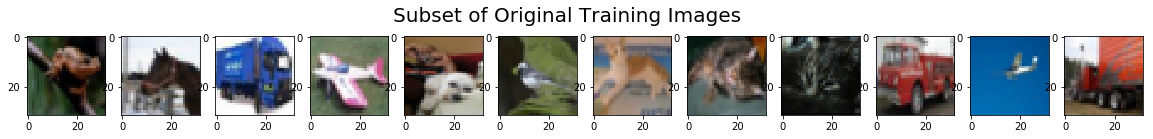

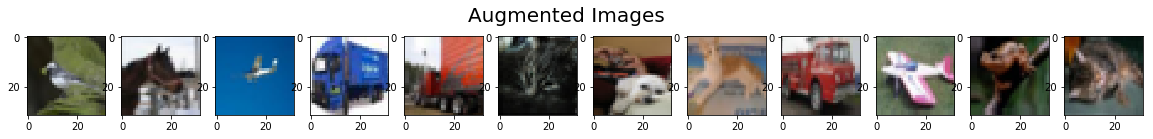

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator for training
datagen_train = ImageDataGenerator(
    rotation_range=0.,
    width_shift_range=0.05,  # randomly shift images horizontally (5% of total width)
    height_shift_range=0.05,  # randomly shift images vertically (5% of total height)
    #shear_range=0.1,  # Shear angle in counter-clockwise direction as radians
    zoom_range=0.,
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator for validation
datagen_valid = ImageDataGenerator(
    rotation_range=0.,
    width_shift_range=0.05,  # randomly shift images horizontally (5% of total width)
    height_shift_range=0.05,  # randomly shift images vertically (5% of total height)
    #shear_range=0.1,
    zoom_range=0.,
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

'''
Visualize original and augmented images
'''

import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12): 
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [5]:
'''
Same model as before
'''

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
__________

In [9]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/100
Epoch 00001: val_loss improved from inf to 1.19606, saving model to aug_model.weights.best.hdf5
 - 26s - loss: 1.2746 - acc: 0.5794 - val_loss: 1.1961 - val_acc: 0.6208
Epoch 2/100
Epoch 00002: val_loss improved from 1.19606 to 1.03313, saving model to aug_model.weights.best.hdf5
 - 26s - loss: 1.2826 - acc: 0.5744 - val_loss: 1.0331 - val_acc: 0.6492
Epoch 3/100
Epoch 00003: val_loss did not improve
 - 28s - loss: 1.3047 - acc: 0.5664 - val_loss: 1.1127 - val_acc: 0.6218
Epoch 4/100
Epoch 00004: val_loss did not improve
 - 26s - loss: 1.3225 - acc: 0.5600 - val_loss: 1.1876 - val_acc: 0.6142
Epoch 5/100
Epoch 00005: val_loss did not improve
 - 26s - loss: 1.3328 - acc: 0.5535 - val_loss: 1.1009 - val_acc: 0.6276
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 26s - loss: 1.3538 - acc: 0.5487 - val_loss: 1.0866 - val_acc: 0.6268
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 26s - loss: 1.3758 - acc: 0.5409 - val_loss: 1.1113 - val_acc: 0.6332
Epoch 8/100
Epoch 0

Epoch 67/100
Epoch 00067: val_loss did not improve
 - 26s - loss: 1.7774 - acc: 0.3535 - val_loss: 1.6617 - val_acc: 0.3874
Epoch 68/100
Epoch 00068: val_loss did not improve
 - 26s - loss: 1.7730 - acc: 0.3619 - val_loss: 1.5658 - val_acc: 0.4377
Epoch 69/100
Epoch 00069: val_loss did not improve
 - 26s - loss: 1.7835 - acc: 0.3589 - val_loss: 1.5927 - val_acc: 0.4193
Epoch 70/100
Epoch 00070: val_loss did not improve
 - 26s - loss: 1.7789 - acc: 0.3564 - val_loss: 1.8022 - val_acc: 0.3738
Epoch 71/100
Epoch 00071: val_loss did not improve
 - 26s - loss: 1.7844 - acc: 0.3543 - val_loss: 1.6762 - val_acc: 0.3706
Epoch 72/100
Epoch 00072: val_loss did not improve
 - 26s - loss: 1.7796 - acc: 0.3579 - val_loss: 1.5988 - val_acc: 0.4123
Epoch 73/100
Epoch 00073: val_loss did not improve
 - 26s - loss: 1.7828 - acc: 0.3580 - val_loss: 1.6446 - val_acc: 0.3800
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 28s - loss: 1.7974 - acc: 0.3496 - val_loss: 1.6581 - val_acc: 0.3900
Epoch 75

In [10]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

('\n', 'Test accuracy:', 0.64280000000000004)
